# Import Library

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
import datetime
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

---

# Load data

### 제공되는 데이터

- Hot Pepper Gourmet (hpg): 사용자들이 레스토랑을 검색하고 온라인 예약할 수 있는 서비스
- AirREGI / Restaurant Board (air): 매장에서 사용하는 예약관리시스템 (POS)
- 훈련 데이터는 2016년~2017년 4월까지, 테스트 데이터는 2017년 4월과 5월 마지막주까지 제공됩니다
- 테스트 데이터에는 골든위크 기간이 포함되어있습니다.
- 테스트 데이터 세트에는 레스토랑이 문을 닫고 방문자가 없는 날이 있었습니다. 스코어링 시 무시됩니다. 훈련 세트는 레스토랑이 문을 닫는 날을 생략합니다.

### 파일 설명

- **air_visit_data.csv**: air 레스토랑의 과거 방문 데이터. 주요 훈련 데이터 세트.
    - air_store_id : air 시스템상의 상점 고유값
    - visit_date : 방문일
    - visitors : 방문자 수 
- **air_reserve.csv / hpg_reserve.csv**: air / hpg 시스템을 통한 예약.
    - air/hpg_store_id : 항공 시스템에서 레스토랑의 id
    - visit_datetime : 예약 시간(방문 시간)
    - reserve_datetime : 예약한 시간
    - reserve_visitors : 해당 예약의 방문자 수
- **air_store_info.csv / hpg_store_info.csv**: 장르 및 위치를 포함한 air / hpg 레스토랑에 대한 세부 정보
    - air/hpg_store_id
    - air/hpg_genre_name
    - air/hpg_area_name
    - latitude
    - longitude
- **store_id_relation.csv**: air와 hpg id를 연결
    - hpg_store_id
    - air_store_id
- **date_info.csv**: 날짜/요일/공휴일 플레그를 포함한 데이터
    - calendar_date : 날짜 (yyyy-mm-dd)
    - day_of_week : 요일
    - holiday_flg : 공휴일 flag (공휴일이면 1, 아니면 0)
- **sample_submission.csv**
    - id는 air_store_idand visit_date를 밑줄 로 연결하여 구성됨
    - visitors는 매장 및 날짜 조합에 대한 예상 방문자 수

<img src="data_diagram.png" width="80%">

In [13]:
data_path = 'data/'

air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(data_path + 'sample_submission.csv')

# EDA

In [5]:
air_visit['visit_date'] = pd.to_datetime(air_visit['visit_date'])

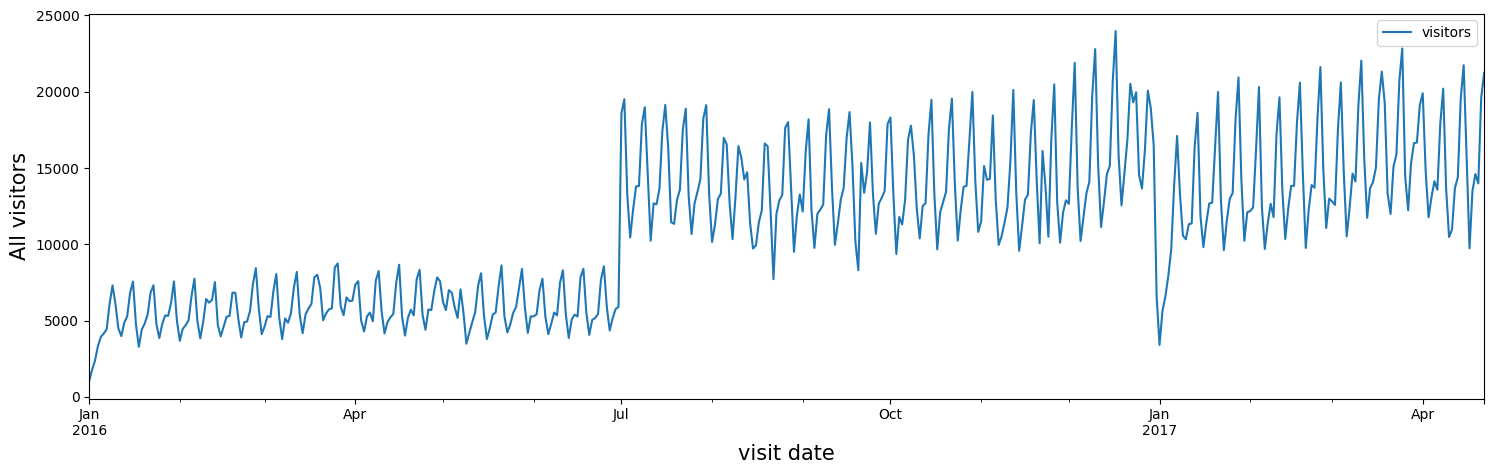

In [6]:
# visit_date을 기준으로 visitor 합계 계산
visitors_by_date = air_visit.groupby(['visit_date']).agg({'visitors': np.sum})

fig,ax = plt.subplots(figsize=(18,5))
visitors_by_date.plot(kind='line', ax=ax)
#visitors_by_date.plot(kind='line', ax=ax)
plt.ylabel('All visitors',fontsize=15)
plt.xlabel('visit date',fontsize=15)
plt.show()

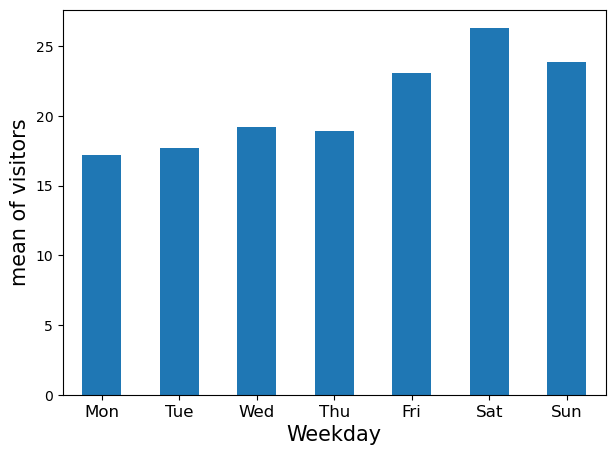

In [33]:
# 요일별 visitor 시각화해서 살펴보기
visitors_by_weekday = air_visit.groupby('dow')['visitors'].mean()

fig,ax = plt.subplots(figsize=(7,5))
ax = visitors_by_weekday.plot(kind='bar', ax=ax)
plt.xlabel('Weekday',fontsize=15)
plt.ylabel('mean of visitors',fontsize=15)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=12, rotation=0)

plt.show()

# Feature Engineering

In [118]:
submission['visit_date'] = submission['id'].str[-10:] # id열에서 visit_date 추출
submission['store_id'] = submission['id'].str[:-11] # id열에서 store_id 추출
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10] 
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek # dow = day of week
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek # (0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일) 
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)
data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek # (0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일) 

# holiday_flg2 : 주말이거나 공휴일이면 1
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

In [119]:
# 'air_area_name0' : 식당이 위치한 지역
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])

# 식당 요리 종류과 지역 레이블 인코딩
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
print(lbl.classes_)
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])
print(lbl.classes_)

['Asian' 'Bar/Cocktail' 'Cafe/Sweets' 'Creative cuisine' 'Dining bar'
 'International cuisine' 'Italian/French' 'Izakaya' 'Japanese food'
 'Karaoke/Party' 'Okonomiyaki/Monja/Teppanyaki' 'Other' 'Western food'
 'Yakiniku/Korean food']
['Fukuoka-ken' 'Hiroshima-ken' 'Hokkaidō' 'Hyōgo-ken' 'Miyagi-ken'
 'Niigata-ken' 'Shizuoka-ken' 'Tōkyō-to' 'Ōsaka-fu']


In [120]:
# 방문자 수 로그변환
# 로그 변환을 하면 상대적으로 작은 값에 몰려 있는 데이터의 모양이 펴지면서 좌우대칭 형태로 분포의 모양이 달라진다.
data['visitors'] = np.log1p(data['visitors']) # log : -inf~  # log1p : 0~

# 방문정보 data와 가게 정보 air_store 결합
data = data.merge(air_store,on='store_id',how='left')

# 가게 및 방문 정보 data와 휴일 정보 date_info 결합
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

In [7]:
###################################### function #########################################
# 리스트 L에 포함된 DataFrame들을 결합하여 하나의 DataFrame으로 만듦
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

# 두 개의 DataFrame인 data1과 data2를 왼쪽 조인하여 병합
def left_merge(data1,data2,on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp,on=on,how='left')
    result = result[columns]
    return result

# 두 개의 날짜를 문자열로 입력받아 날짜 간의 차이를 일 단위로 계산하여 반환
def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

# 주어진 날짜(start_date)에 특정 일 수(days)를 더해 새로운 날짜를 반환
def date_add_days(start_date, days):
    end_date = parse(start_date[:10]) + timedelta(days=days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date

# 주어진 end_date에 n_day를 더한 날짜를 기준으로 데이터프레임을 추출
def get_label(end_date,n_day):
    label_end_date = date_add_days(end_date, n_day)
    label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
    label['end_date'] = end_date
    label['diff_of_day'] = label['visit_date'].apply(lambda x: diff_of_days(x,end_date))
    label['month'] = label['visit_date'].str[5:7].astype(int)
    label['year'] = label['visit_date'].str[:4].astype(int)
    for i in [3,2,1,-1]:
        date_info_temp = date_info.copy()
        date_info_temp['visit_date'] = date_info_temp['visit_date'].apply(lambda x: date_add_days(x,i))
        date_info_temp.rename(columns={'holiday_flg':'ahead_holiday_{}'.format(i),'holiday_flg2':'ahead_holiday2_{}'.format(i)},inplace=True)
        label = label.merge(date_info_temp, on=['visit_date'],how='left')
    label = label.reset_index(drop=True)
    return label
# 예) 2017.03.12에 39일을 더한 날짜(= 대략 2017.04.20)를 기준으로 데이터프레임을 추출
# data에서 visit_date가 2017.03.12보다 작고 2017.04.20보다 작거나 같은 행들을 추출하여 label 데이터프레임 생성
# end_date : 2017.03.12 
# n_day : 39
# label_end_date : 2017.04.20
# diff_of_day : visit_date와 2017.03.12 사이의 날짜 차이
# month & year : visit_date의 월, 연도
# ahead_holiday_i & ahead_holiday2_i : date_info에서 (visit_date + i) 날짜의 휴일 여부 (미래의 휴일 여부)


# 레이블 데이터(label)와 날짜 정보(key[0])를 기준으로 이전 n_day일 동안의 방문자 수에 대한 통계 정보를 계산
def get_store_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_min{}'.format(n_day): 'min',
                                                                             'store_mean{}'.format(n_day): 'mean',
                                                                             'store_median{}'.format(n_day): 'median',
                                                                             'store_max{}'.format(n_day): 'max',
                                                                             'store_count{}'.format(n_day): 'count',
                                                                             'store_std{}'.format(n_day): 'std',
                                                                             'store_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result
# key : 2017.03.12, 39
# 예) 2017.03.12에서 39일을 빼면 2017.02.02가 나옴. 
# 가게 및 방문 정보 데이터 data에서 2017.02.02~2017.03.12 사이의 행들을 추출하여 data_temp에 저장
# data_temp에서 store_id별로 방문자들에 대한 집계 함수 적용 후 result에 저장
# label과 result를 store_id 기준으로 왼쪽 조인 병합 후 결측값은 0으로 채움
# 이로써 리턴값은 label의 store_id에 해당하는 행들에 대한 방문자 수 통계 정보가 추가됨
# start_date : 2017.02.02


# 레이블 데이터(label)와 날짜 정보(key[0])를 기준으로 이전 n_day일 동안의 방문자 수에 지수 가중치를 적용하여 가중 평균을 계산하여 해당 열 추가
def get_store_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x) # 방문날짜가 key 날짜로부터 멀수록 가중치 감소
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['store_id'], as_index=False)['weight'].agg({'store_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['store_id'], how='left')
    result['store_exp_mean{}'.format(n_day)] = result['store_exp_mean{}'.format(n_day)]/result['store_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result
# result 데이터프레임에는 label의 'store_id'에 해당하는 행들에 대한 방문자 수에 대한 가중 평균이 추가됨



# 레이블 데이터(label)와 날짜 정보(key[0])를 기준으로 이전 n_day일 동안의 각 매장(store_id) 및 요일(dow) 별 방문자 수에 대한 통계 정보를 계산
# 요일(dow)에 대한 통계 정보를 각각 따로 계산
# 요일(dow)에 대한 통계 정보를 여러 개의 컬럼으로 저장
def get_store_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors'].agg({'store_dow_min{}'.format(n_day): 'min',
                                                                                     'store_dow_mean{}'.format(n_day): 'mean',
                                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                                     'store_dow_max{}'.format(n_day): 'max',
                                                                                     'store_dow_count{}'.format(n_day): 'count',
                                                                                     'store_dow_std{}'.format(n_day): 'std',
                                                                                     'store_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result
# result 데이터프레임에는 label의 'store_id'와 'dow'에 해당하는 행들에 대한 방문자 수 통계 정보가 추가됨



# 레이블 데이터(label)와 날짜 정보(key[0])를 기준으로 이전 n_day일 동안의 각 매장(store_id) 별 방문자 수 변동에 대한 통계 정보를 계산
def get_store_week_diff_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.set_index(['store_id','visit_date'])['visitors'].unstack()
    result = result.diff(axis=1).iloc[:,1:]
    c = result.columns
    result['store_diff_mean'] = np.abs(result[c]).mean(axis=1) # 단순 크기를 사용하며 시간이 길어질수록 평균값이 (+-상쇄되어) 0에 가까워지므로 절대값 사용
    result['store_diff_std'] = result[c].std(axis=1)
    result['store_diff_max'] = result[c].max(axis=1)
    result['store_diff_min'] = result[c].min(axis=1)
    result = left_merge(label, result[['store_diff_mean', 'store_diff_std', 'store_diff_max', 'store_diff_min']],on=['store_id']).fillna(0)
    return result
# result 데이터프레임에는 label의 'store_id'에 해당하는 행들에 대한 방문자 수 변동의 평균, 표준편차, 최댓값, 최솟값이 추가됨


# 레이블 데이터(label)와 날짜 정보(key[0])를 기준으로 이전 n_day일 동안의 각 매장(store_id) 및 요일(dow) 별 방문자 수에 대한 통계 정보를 계산
# 모든 요일에 대한 통계 정보를 한 번에 계산
# 모든 요일에 대한 통계 정보를 각각 다른 컬럼에 저장
def get_store_all_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result_temp = data_temp.groupby(['store_id', 'dow'],as_index=False)['visitors'].agg({'store_dow_mean{}'.format(n_day): 'mean',
                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                     'store_dow_sum{}'.format(n_day): 'max',
                                                                     'store_dow_count{}'.format(n_day): 'count'})
    result = pd.DataFrame()
    for i in range(7):
        result_sub = result_temp[result_temp['dow']==i].copy()
        result_sub = result_sub.set_index('store_id')
        result_sub = result_sub.add_prefix(str(i))
        result_sub = left_merge(label, result_sub, on=['store_id']).fillna(0)
        result = pd.concat([result,result_sub],axis=1)
    return result
#  result 데이터프레임에는 label의 'store_id'에 해당하는 행들에 대해 모든 요일 별 방문자 수에 대한 통계 정보가 추가됨



# label의 'store_id'와 'dow'에 해당하는 행들에 대해 방문자 수에 대한 가중치가 적용된 평균값과 또 다른 가중치가 적용된 평균값에 대한 정보가 담긴 result 데이터프레임을 반환
def get_store_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['visitors2'] = data_temp['visitors']
    result = None
    for i in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
        data_temp['weight'] = data_temp['visit_date'].apply(lambda x: i**x)
        data_temp['visitors1'] = data_temp['visitors'] * data_temp['weight']
        data_temp['visitors2'] = data_temp['visitors2'] * data_temp['weight']
        result1 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors1'].agg({'store_dow_exp_mean{}_{}'.format(n_day,i): 'sum'})
        result3 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors2'].agg({'store_dow_exp_mean2{}_{}'.format(n_day, i): 'sum'})
        result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['weight'].agg({'store_dow_exp_weight_sum{}_{}'.format(n_day,i): 'sum'})
        result_temp = result1.merge(result2, on=['store_id', 'dow'], how='left')
        result_temp = result_temp.merge(result3, on=['store_id', 'dow'], how='left')
        result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)] = result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day,i)]
        result_temp['store_dow_exp_mean2{}_{}'.format(n_day, i)] = result_temp[ 'store_dow_exp_mean2{}_{}'.format(n_day, i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day, i)]
        if result is None:
            result = result_temp
        else:
            result = result.merge(result_temp,on=['store_id','dow'],how='left')
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result
#  label의 각 행에 해당하는 'store_id'와 'dow' 별로 방문자 수에 대한 가중 평균값이 result 데이터프레임에 담기게 됨


# 'store_id', 'holiday_flg', 'holiday_flg2'를 기준으로 데이터를 그룹화하여 해당 그룹들의 방문자 수에 대한 통계 정보를 계산
def get_store_holiday_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result1 = data_temp.groupby(['store_id', 'holiday_flg'], as_index=False)['visitors'].agg(
        {'store_holiday_min{}'.format(n_day): 'min',
         'store_holiday_mean{}'.format(n_day): 'mean',
         'store_holiday_median{}'.format(n_day): 'median',
         'store_holiday_max{}'.format(n_day): 'max',
         'store_holiday_count{}'.format(n_day): 'count',
         'store_holiday_std{}'.format(n_day): 'std',
         'store_holiday_skew{}'.format(n_day): 'skew'})
    result1 = left_merge(label, result1, on=['store_id', 'holiday_flg']).fillna(0)
    result2 = data_temp.groupby(['store_id', 'holiday_flg2'], as_index=False)['visitors'].agg(
        {'store_holiday2_min{}'.format(n_day): 'min',
         'store_holiday2_mean{}'.format(n_day): 'mean',
         'store_holiday2_median{}'.format(n_day): 'median',
         'store_holiday2_max{}'.format(n_day): 'max',
         'store_holiday2_count{}'.format(n_day): 'count',
         'store_holiday2_std{}'.format(n_day): 'std',
         'store_holiday2_skew{}'.format(n_day): 'skew'})
    result2 = left_merge(label, result2, on=['store_id', 'holiday_flg2']).fillna(0)
    result = pd.concat([result1, result2], axis=1)
    return result



# 'air_genre_name'을 기준으로 데이터를 그룹화하여 해당 그룹들의 방문자 수에 대한 통계 정보를 계산
def get_genre_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_min{}'.format(n_day): 'min',
                                                                             'genre_mean{}'.format(n_day): 'mean',
                                                                             'genre_median{}'.format(n_day): 'median',
                                                                             'genre_max{}'.format(n_day): 'max',
                                                                             'genre_count{}'.format(n_day): 'count',
                                                                             'genre_std{}'.format(n_day): 'std',
                                                                             'genre_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result
# label의 각 행에 해당하는 'air_genre_name' 별로 방문자 수에 대한 통계 정보를 얻을 수 있음



# 'air_genre_name'을 기준으로 데이터를 그룹화하여 해당 그룹들의 가중 평균 방문자 수를 계산
def get_genre_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name'], as_index=False)['weight'].agg({'genre_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name'], how='left')
    result['genre_exp_mean{}'.format(n_day)] = result['genre_exp_mean{}'.format(n_day)]/result['genre_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result
# label의 각 행에 해당하는 'air_genre_name' 별로 가중 평균 방문자 수를 얻을 수 있음


#  'air_genre_name'과 'dow'를 기준으로 데이터를 그룹화하여 해당 그룹들의 방문자 수에 대한 요일별 통계 정보를 계산
def get_genre_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_min{}'.format(n_day): 'min',
                                                                                         'genre_dow_mean{}'.format(n_day): 'mean',
                                                                                         'genre_dow_median{}'.format(n_day): 'median',
                                                                                         'genre_dow_max{}'.format(n_day): 'max',
                                                                                         'genre_dow_count{}'.format(n_day): 'count',
                                                                                         'genre_dow_std{}'.format(n_day): 'std',
                                                                                         'genre_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result
# label의 각 행에 해당하는 'air_genre_name'과 'dow' 별로 방문자 수에 대한 요일별 통계 정보를 얻을 수 있음



# 'air_genre_name'과 'dow'를 기준으로 데이터를 그룹화하여 해당 그룹들의 가중 평균 방문자 수를 계산
def get_genre_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['weight'].agg({'genre_dow_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name', 'dow'], how='left')
    result['genre_dow_exp_mean{}'.format(n_day)] = result['genre_dow_exp_mean{}'.format(n_day)]/result['genre_dow_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result
# label의 각 행에 해당하는 'air_genre_name'과 'dow' 별로 가중 평균 방문자 수를 얻을 수 있음


# 'store_id'를 기준으로 데이터를 그룹화하여 해당 그룹들의 첫 방문 날짜와 마지막 방문 날짜에 대한 정보를 계산
def get_first_last_time(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp = data_temp.sort_values('visit_date')
    result = data_temp.groupby('store_id')['visit_date'].agg(first_time = lambda x: diff_of_days(key[0],np.min(x)),
                                                              last_time = lambda x: diff_of_days(key[0],np.max(x)))
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result
# label의 각 행에 해당하는 'store_id' 별로 첫 방문 날짜와 마지막 방문 날짜에 대한 정보를 얻을 수 있음



# air_reserve
# 'air_reserve'와 'hpg_reserve' 데이터를 이용하여 예약과 방문 관련 특징을 계산
def get_reserve_feat(label,key):
    label_end_date = date_add_days(key[0], key[1])
    air_reserve_temp = air_reserve[(air_reserve.visit_date >= key[0]) &             
                                   (air_reserve.visit_date < label_end_date) &      
                                   (air_reserve.reserve_date < key[0])].copy()
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id',how='left')
    air_reserve_temp['diff_time'] = (pd.to_datetime(air_reserve_temp['visit_datetime'])-pd.to_datetime(air_reserve_temp['reserve_datetime'])).dt.days
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id')
    air_result = air_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(
        air_reserve_visitors = 'sum',
         air_reserve_count = 'count')
    air_store_diff_time_mean = air_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        air_store_diff_time_mean = 'mean')
    air_diff_time_mean = air_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        air_diff_time_mean = 'mean')
    air_result = air_result.unstack().fillna(0).stack()
    air_date_result = air_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg(
        air_date_visitors = 'sum',
        air_date_count = 'count')
    hpg_reserve_temp = hpg_reserve[(hpg_reserve.visit_date >= key[0]) & (hpg_reserve.visit_date < label_end_date) & (hpg_reserve.reserve_date < key[0])].copy()
    hpg_reserve_temp['diff_time'] = (pd.to_datetime(hpg_reserve_temp['visit_datetime']) - pd.to_datetime(hpg_reserve_temp['reserve_datetime'])).dt.days
    hpg_result = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(hpg_reserve_visitors = 'sum',
                                                                                               hpg_reserve_count = 'count')
    hpg_result = hpg_result.unstack().fillna(0).stack()
    hpg_date_result = hpg_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg(
        hpg_date_visitors = 'sum',
        hpg_date_count = 'count')
    hpg_store_diff_time_mean = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        hpg_store_diff_time_mean = 'mean')
    hpg_diff_time_mean = hpg_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        hpg_diff_time_mean = 'mean')
    air_result = left_merge(label, air_result, on=['store_id','visit_date']).fillna(0)
    air_store_diff_time_mean = left_merge(label, air_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    hpg_result = left_merge(label, hpg_result, on=['store_id', 'visit_date']).fillna(0)
    hpg_store_diff_time_mean = left_merge(label, hpg_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    air_date_result = left_merge(label, air_date_result, on=['visit_date']).fillna(0)
    air_diff_time_mean = left_merge(label, air_diff_time_mean, on=['visit_date']).fillna(0)
    hpg_date_result = left_merge(label, hpg_date_result, on=['visit_date']).fillna(0)
    hpg_diff_time_mean = left_merge(label, hpg_diff_time_mean, on=['visit_date']).fillna(0)
    result = pd.concat([air_result,hpg_result,air_date_result,hpg_date_result,air_store_diff_time_mean,
                        hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean],axis=1)
    return result
# 각 가게별, 방문 날짜별, 그리고 날짜별 예약 및 방문 정보에 대한 특징을 계산 
# 예약과 방문 수, 예약과 방문 사이의 시간 간격 등을 계산하여 label 데이터에 병합


# second feature
#  result 데이터프레임에 여러 가게와 장르에 관련된 특징들을 계산하여 새로운 특징들을 추가
def second_feat(result):
    result['store_mean_14_28_rate'] = result['store_mean14']/(result['store_mean28']+0.01)
    result['store_mean_28_56_rate'] = result['store_mean28'] / (result['store_mean56'] + 0.01)
    result['store_mean_56_1000_rate'] = result['store_mean56'] / (result['store_mean1000'] + 0.01)
    result['genre_mean_28_56_rate'] = result['genre_mean28'] / (result['genre_mean56'] + 0.01)
    result['sgenre_mean_56_1000_rate'] = result['genre_mean56'] / (result['genre_mean1000'] + 0.01)
    return result
# 추가된 특징들은 가게와 장르의 방문자 수 변화를 시간 간격별로 비교하며, 특히 14일, 28일, 56일, 1000일 등의 기간을 비교하여 방문자 수의 추세를 파악하는데 도움을 줍니다. 
# 이러한 특징들을 활용하여 더 다양하고 효과적인 예측 모델을 만들 수 있음


# Train data 만들기
# 다양한 기간별 방문자 수, 예약 관련 정보, 가게 및 장르 특징 등을 포함하여 데이터셋을 구성하고, 예측 모델을 학습하기 위한 특징들을 추출하는 중요한 함수입니다. 
# 이를 통해 데이터를 구성하고 다양한 시계열 특징을 활용하여 모델의 성능을 향상시킬 수 있습니다.
# 주어진 기간 동안의 데이터를 사용하여 특징을 추출하는 함수
def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    print('data key：{}'.format(key))
    print('add label')
    label = get_label(end_date,n_day)  # label : end_date에 n_day를 더한 날짜를 기준으로 데이터프레임을 추출

    print('make feature...')
    result = [label]
    # label와 날짜 정보(key[0] = end_date)를 기준으로 이전 (1000,56,28,14)일 동안의 방문자 수에 대한 통계 정보를 계산
    result.append(get_store_visitor_feat(label, key, 1000))        # store features
    result.append(get_store_visitor_feat(label, key, 56))          # store features
    result.append(get_store_visitor_feat(label, key, 28))          # store features
    result.append(get_store_visitor_feat(label, key, 14))          # store features
    
    # label와 날짜 정보(key[0])를 기준으로 이전 (1000)일 동안의 방문자 수에 지수 가중치를 적용하여 가중 평균을 계산하여 해당 열 추가
    result.append(get_store_exp_visitor_feat(label, key, 1000))    # store exp features
    
    # label와 날짜 정보(key[0])를 기준으로 이전 (1000,56,28,14)일 동안의 각 매장(store_id) 및 요일(dow) 별 방문자 수에 대한 통계 정보를 계산
    # 요일(dow)에 대한 통계 정보를 각각 따로 계산
    # 요일(dow)에 대한 통계 정보를 여러 개의 컬럼으로 저장
    result.append(get_store_week_feat(label, key, 1000))           # store dow features
    result.append(get_store_week_feat(label, key, 56))             # store dow features
    result.append(get_store_week_feat(label, key, 28))             # store dow features
    result.append(get_store_week_feat(label, key, 14))             # store dow features
    
    # label와 날짜 정보(key[0])를 기준으로 이전 (58,1000)일 동안의 각 매장(store_id) 별 방문자 수 변동에 대한 통계 정보를 계산
    result.append(get_store_week_diff_feat(label, key, 58))       # store dow diff features
    result.append(get_store_week_diff_feat(label, key, 1000))      # store dow diff features
    
    # label와 날짜 정보(key[0])를 기준으로 이전 (1000)일 동안의 각 매장(store_id) 및 요일(dow) 별 방문자 수에 대한 통계 정보를 계산
    # 모든 요일(=week)에 대한 통계 정보를 한 번에 계산
    # 모든 요일에 대한 통계 정보를 각각 다른 컬럼에 저장
    result.append(get_store_all_week_feat(label, key, 1000))       # store all week feat
    
    # label의 'store_id'와 'dow'에 해당하는 행들에 대해 방문자 수에 대한 여러 가중치가 적용된 평균값에 대한 정보가 담긴 result 데이터프레임을 반환
    result.append(get_store_week_exp_feat(label, key, 1000))       # store dow exp feat
    
    # store_id', 'holiday_flg', 'holiday_flg2'를 기준으로 데이터를 그룹화하여 해당 그룹들의 방문자 수에 대한 통계 정보를 계산
    result.append(get_store_holiday_feat(label, key, 1000))        # store holiday feat
    
    
    # 'air_genre_name'을 기준으로 데이터를 그룹화하여 해당 그룹들의 이전 (1000,56,28)일 동안의 방문자 수에 대한 통계 정보를 계산
    result.append(get_genre_visitor_feat(label, key, 1000))         # genre feature
    result.append(get_genre_visitor_feat(label, key, 56))           # genre feature
    result.append(get_genre_visitor_feat(label, key, 28))           # genre feature
    
    # 'air_genre_name'을 기준으로 데이터를 그룹화하여 해당 그룹들의 가중 평균 방문자 수를 계산
    result.append(get_genre_exp_visitor_feat(label, key, 1000))     # genre feature
    
    # 'air_genre_name'과 'dow'를 기준으로 데이터를 그룹화하여 해당 그룹들의 방문자 수에 대한 요일별 통계 정보를 계산
    result.append(get_genre_week_feat(label, key, 1000))            # genre dow feature
    result.append(get_genre_week_feat(label, key, 56))              # genre dow feature
    result.append(get_genre_week_feat(label, key, 28))              # genre dow feature
    
    # 'air_genre_name'과 'dow'를 기준으로 데이터를 그룹화하여 해당 그룹들의 가중 평균 방문자 수를 계산
    result.append(get_genre_week_exp_feat(label, key, 1000))        # genre dow exp feature
    
    # 'air_reserve'와 'hpg_reserve' 데이터를 이용하여 예약과 방문 관련 특징을 계산
    result.append(get_reserve_feat(label,key))                      # air_reserve
    
    # 'store_id'를 기준으로 데이터를 그룹화하여 해당 그룹들의 첫 방문 날짜와 마지막 방문 날짜에 대한 정보를 계산
    result.append(get_first_last_time(label,key,1000))             # first time and last time

    result.append(label)

    print('merge...')
    result = concat(result)
    
    # 가게와 장르의 방문자 수 변화를 시간 간격별로 비교하며, 특히 14일, 28일, 56일, 1000일 등의 기간을 비교하여 방문자 수의 추세를 파악하는 컬럼 추가
    result = second_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result


In [122]:
train_feat = pd.DataFrame()
start_date = '2017-03-12'

In [123]:
for i in range(58):
    train_feat_sub = make_feats(date_add_days(start_date, i*(-7)),39)
    train_feat = pd.concat([train_feat,train_feat_sub])
for i in range(1,6):
    train_feat_sub = make_feats(date_add_days(start_date,i*(7)),42-(i*7))
    train_feat = pd.concat([train_feat,train_feat_sub])
test_feat = make_feats(date_add_days(start_date, 42),39)

data key：('2017-03-12', 39)
add label
make feature...
merge...
data shape：(27728, 224)
spending 53.71629071235657s
data key：('2017-03-05', 39)
add label
make feature...
merge...
data shape：(27705, 224)
spending 53.42618775367737s
data key：('2017-02-26', 39)
add label
make feature...
merge...
data shape：(27745, 224)
spending 53.31636881828308s
data key：('2017-02-19', 39)
add label
make feature...
merge...
data shape：(27696, 224)
spending 52.6063597202301s
data key：('2017-02-12', 39)
add label
make feature...
merge...
data shape：(27596, 224)
spending 51.00983214378357s
data key：('2017-02-05', 39)
add label
make feature...
merge...
data shape：(27561, 224)
spending 49.30327749252319s
data key：('2017-01-29', 39)
add label
make feature...
merge...
data shape：(27511, 224)
spending 49.126392126083374s
data key：('2017-01-22', 39)
add label
make feature...
merge...
data shape：(27474, 224)
spending 47.55771279335022s
data key：('2017-01-15', 39)
add label
make feature...
merge...
data shape：(27389

In [124]:
predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

In [100]:
train_feat.shape

(1322337, 224)

In [41]:
len(predictors)

217

In [42]:
predictors

['dow',
 'air_genre_name',
 'latitude',
 'longitude',
 'air_area_name0',
 'holiday_flg',
 'holiday_flg2',
 'diff_of_day',
 'year',
 'ahead_holiday_3',
 'ahead_holiday2_3',
 'ahead_holiday_2',
 'ahead_holiday2_2',
 'ahead_holiday_1',
 'ahead_holiday2_1',
 'ahead_holiday_-1',
 'ahead_holiday2_-1',
 'store_min1000',
 'store_mean1000',
 'store_median1000',
 'store_max1000',
 'store_count1000',
 'store_std1000',
 'store_skew1000',
 'store_min56',
 'store_mean56',
 'store_median56',
 'store_max56',
 'store_count56',
 'store_std56',
 'store_skew56',
 'store_min28',
 'store_mean28',
 'store_median28',
 'store_max28',
 'store_count28',
 'store_std28',
 'store_skew28',
 'store_min14',
 'store_mean14',
 'store_median14',
 'store_max14',
 'store_count14',
 'store_std14',
 'store_skew14',
 'store_exp_mean1000',
 'store_exp_weight_sum1000',
 'store_dow_min1000',
 'store_dow_mean1000',
 'store_dow_median1000',
 'store_dow_max1000',
 'store_dow_count1000',
 'store_dow_std1000',
 'store_dow_skew1000',


In [151]:
params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
    'random_state': 42
}

In [18]:
t0 = time.time()
lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

In [19]:
gbm = lgb.train(params,lgb_train,2300)
pred = gbm.predict(test_feat[predictors])

# Make Submission

In [22]:
print('걸린 시간 {}초'.format(time.time() - t0))
subm = pd.DataFrame({'id':test_feat.store_id + '_' + test_feat.visit_date,'visitors':np.expm1(pred)})
subm = submission[['id']].merge(subm,on='id',how='left').fillna(0)

subm.to_csv(r'.\sub_lgbm_{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
                  index=False,  float_format='%.4f')

걸린 시간 355.2657175064087초
